# eBOSS v6 Analyses

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os
import fitsio as ft
import healpy as hp
import numpy as np
from   glob import glob
import pandas as pd
import seaborn as sns

# PATHS to my storage
# mehdi  @ cori
# rezaie @ OU iMac
HOME    = os.getenv('HOME')
USER    = os.getenv('USER')
sys.path.append(HOME + '/github/SYSNet/src')
from prepare import CAT, combinemaps, hd5_2_fits
from dataviz import hyper_params_data
import utils as ut
#from utils import split2Kfolds, split2KfoldsSpatially
dirs    = dict(rezaie='/Volumes/TimeMachine/data/', mehdi='/global/cscratch1/sd/mehdi/')
scratch = dirs[USER]
print('home is {}'.format(HOME))

camb is not installed!
home is /Users/rezaie
home is /Users/rezaie


## project catalogs to healpix maps, prepare for regression and clustering

Jul 24:  w1_moon is zero for all NGC pixels, we removed it!

### SGC+NGC

len of gal cats 2
num of gal obj 342394
projecting into a healpix map with nside of 512


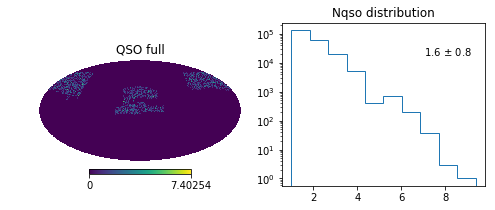

len of gal cats 2
num of gal obj 342394
projecting into a healpix map with nside of 512


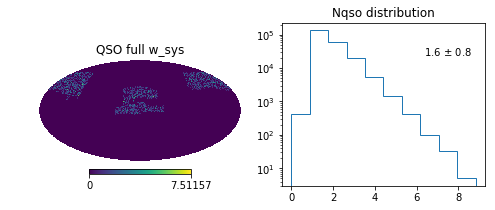

len of gal cats 2
num of gal obj 9153197
projecting into a healpix map with nside of 512


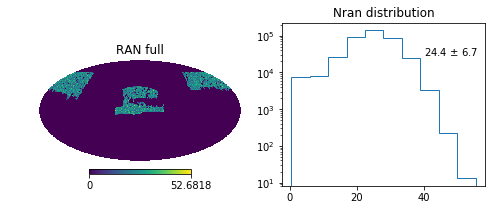

attributes : ('nran', 'sky_g', 'sky_r', 'sky_i', 'sky_z', 'airmass', 'ebv', 'depth_g', 'depth_r', 'depth_i', 'depth_z', 'psf_g', 'psf_r', 'psf_i', 'psf_z', 'w1_med', 'w1_covmed', 'w1_moon', 'star_density')
total mask ran > 0 : 392584
total mask after nan maps : 392502
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145728 entries, 0 to 3145727
Data columns (total 20 columns):
ngal            float64
nran            float64
mask            bool
sky_g           float64
sky_r           float64
sky_i           float64
sky_z           float64
depth_g         float64
depth_r         float64
depth_i         float64
depth_z         float64
psf_g           float64
psf_r           float64
psf_i           float64
psf_z           float64
w1_med          float64
w1_covmed       float64
star_density    float64
ebv             float64
airmass         float64
dtypes: bool(1), float64(19)
memory usage: 459.0 MB
Info :  None



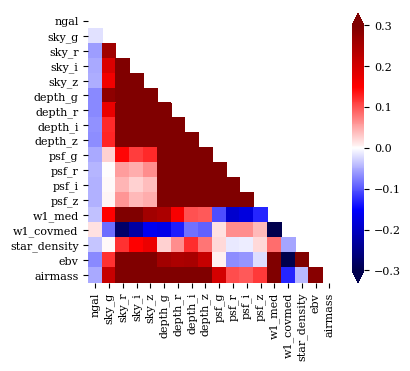

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


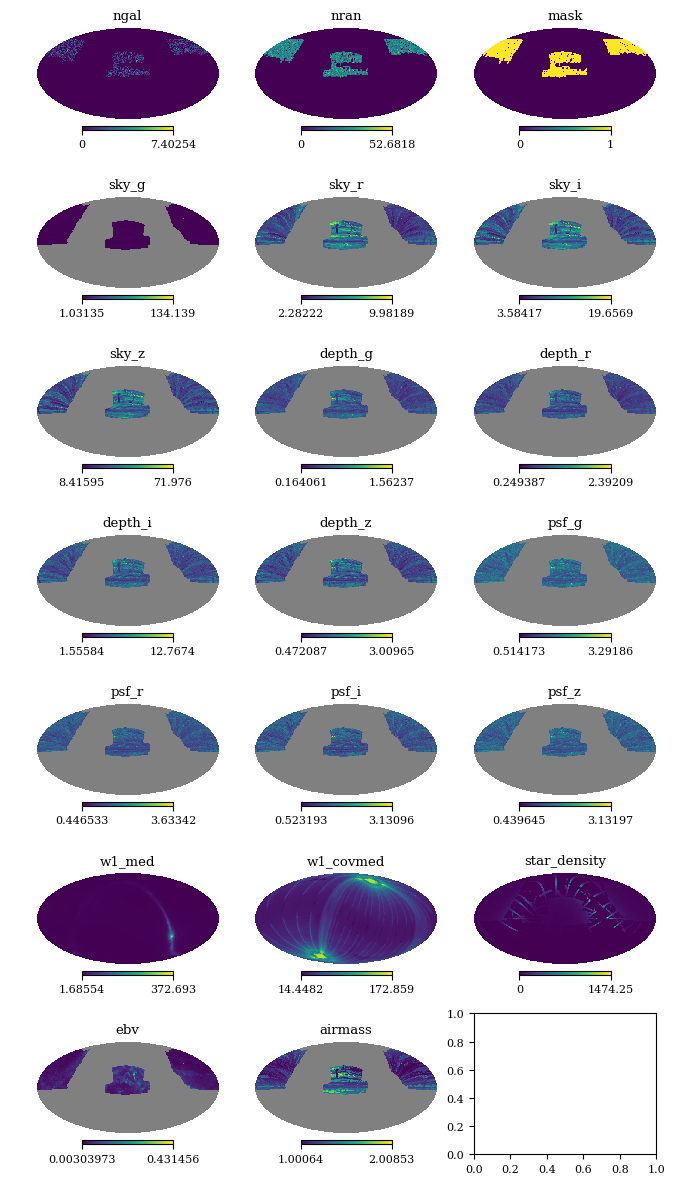

wrote /Volumes/TimeMachine/data/eboss/v6/ngal_features_all.fits
wrote /Volumes/TimeMachine/data/eboss/v6/mask.all.hp.512.fits
wrote /Volumes/TimeMachine/data/eboss/v6/fracgood.all.hp.512.fits


In [2]:
# data
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits', 
              scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.dat.fits'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_all_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO full', 'Nqso distribution'])

# data with systot
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits', 
              scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.dat.fits'], 
            weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_all_wsys_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO full w_sys', 'Nqso distribution'])

# random
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.ran.fits', 
              scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.ran.fits'],
             weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_all_v6.ran.hp.512.fits')
qsocat.plot_hist(['RAN full', 'Nran distribution'])


# combine them
COLS = ['sky_g', 'sky_r', 'sky_i', 'sky_z', 
        'depth_g', 'depth_r', 'depth_i','depth_z',
        'psf_g','psf_r', 'psf_i', 'psf_z',
        'w1_med', 'w1_covmed',
        'star_density', 'ebv', 'airmass']
pdm = combinemaps(scratch+'eboss/v6/eBOSS_QSO_clustering_all_v6.dat.hp.512.fits',
                  scratch+'eboss/v6/eBOSS_QSO_clustering_all_v6.ran.hp.512.fits',
                  scratch +'/eboss/sysmaps/SDSS_WISE_imageprop_nside512.fits')
pdm.maketable(cols=COLS)
pdm.to_hdf(scratch+'eboss/v6/qso_hpsyst_all.hf', 'qso_hpsyst', mode='w', format='fixed')
pdm.plot_corrmax([-.3, .3])
pdm.plot_mollweide()

# read hdf, write label, features to fits
fitname = '/Volumes/TimeMachine/data/eboss/v6/ngal_features_all.fits'
metaname = '/Volumes/TimeMachine/data/eboss/v6/qso_hpsyst_all.hf'
hpmask   = '/Volumes/TimeMachine/data/eboss/v6/mask.all.hp.512.fits'
hpfrac   = '/Volumes/TimeMachine/data/eboss/v6/fracgood.all.hp.512.fits'
hd5_2_fits(metaname, fitname, hpmask, hpfrac, COLS)

# randomly split the label features into 5 partitions
ut.read_split_write('/Volumes/TimeMachine/data/eboss/v6/ngal_features_all.fits', 
                   '/Volumes/TimeMachine/data/eboss/v6/qso.all.hp.512.r',
                   5)

### NGC

len of gal cats 1
num of gal obj 216893
projecting into a healpix map with nside of 512
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_ngc_v6.dat.hp.512.fits already exists going to rewrite....


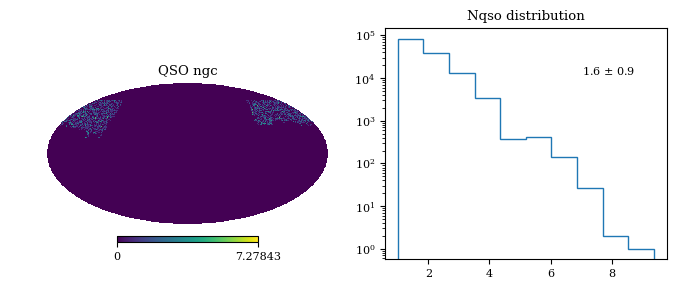

len of gal cats 1
num of gal obj 216893
projecting into a healpix map with nside of 512


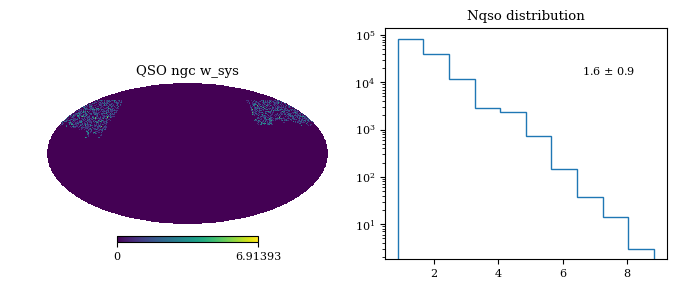

len of gal cats 1
num of gal obj 5565871
projecting into a healpix map with nside of 512
/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_ngc_v6.ran.hp.512.fits already exists going to rewrite....


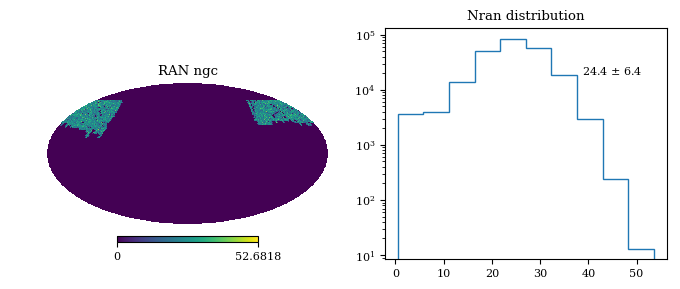

attributes : ('nran', 'sky_g', 'sky_r', 'sky_i', 'sky_z', 'airmass', 'ebv', 'depth_g', 'depth_r', 'depth_i', 'depth_z', 'psf_g', 'psf_r', 'psf_i', 'psf_z', 'w1_med', 'w1_covmed', 'w1_moon', 'star_density')
total mask ran > 0 : 237261
total mask after nan maps : 237220
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145728 entries, 0 to 3145727
Data columns (total 20 columns):
ngal            float64
nran            float64
mask            bool
sky_g           float64
sky_r           float64
sky_i           float64
sky_z           float64
depth_g         float64
depth_r         float64
depth_i         float64
depth_z         float64
psf_g           float64
psf_r           float64
psf_i           float64
psf_z           float64
w1_med          float64
w1_covmed       float64
star_density    float64
ebv             float64
airmass         float64
dtypes: bool(1), float64(19)
memory usage: 459.0 MB
Info :  None
/Volumes/TimeMachine/data/eboss/v6/qso_hpsyst_ngc.hf already exists going to

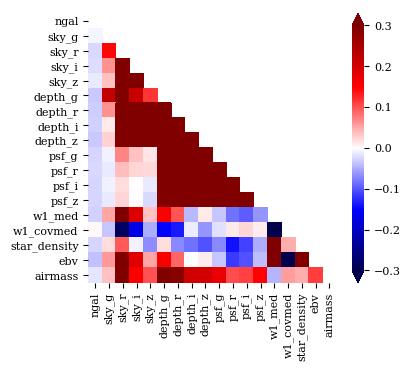

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


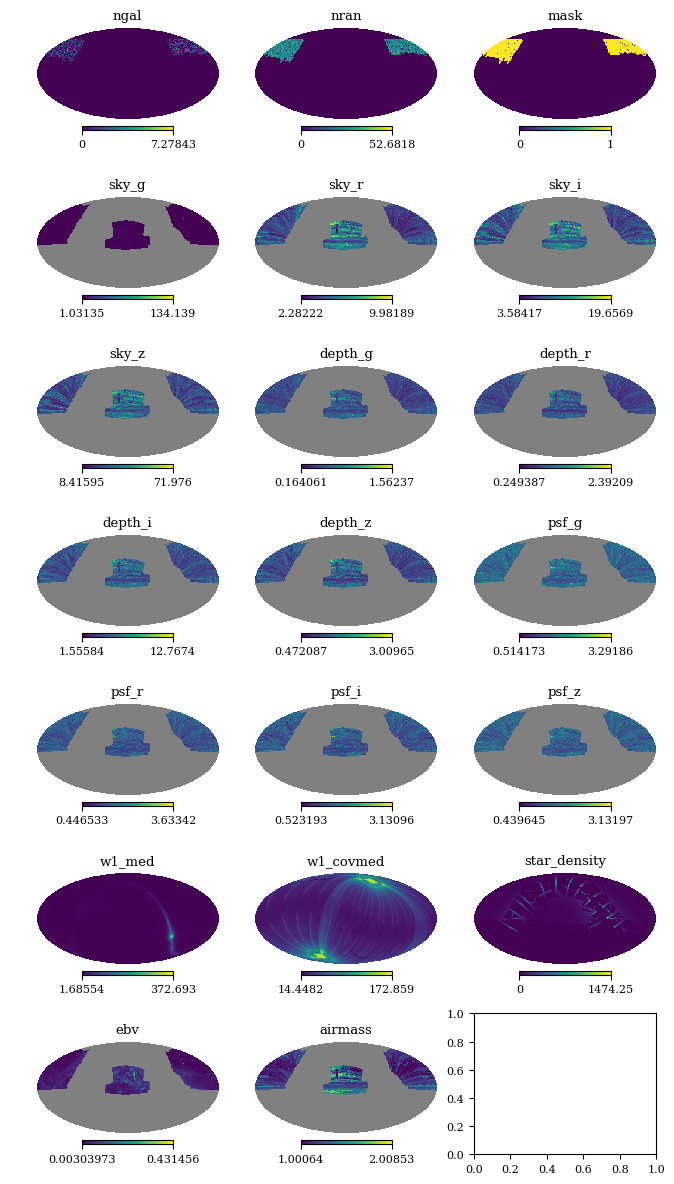

wrote /Volumes/TimeMachine/data/eboss/v6/ngal_features_ngc.fits
wrote /Volumes/TimeMachine/data/eboss/v6/mask.ngc.hp.512.fits
wrote /Volumes/TimeMachine/data/eboss/v6/fracgood.ngc.hp.512.fits


In [4]:
# data
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_ngc_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO ngc', 'Nqso distribution'])

# data with systot
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits'], 
            weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_ngc_wsys_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO ngc w_sys', 'Nqso distribution'])

# random
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_NGC_v6.ran.fits'],
             weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_ngc_v6.ran.hp.512.fits')
qsocat.plot_hist(['RAN ngc', 'Nran distribution'])


# combine data, random, and imaging attributes
COLS = ['sky_g', 'sky_r', 'sky_i', 'sky_z', 
        'depth_g', 'depth_r', 'depth_i','depth_z',
        'psf_g','psf_r', 'psf_i', 'psf_z',
        'w1_med', 'w1_covmed',
        'star_density', 'ebv', 'airmass']

pdm = combinemaps(scratch+'eboss/v6/eBOSS_QSO_clustering_ngc_v6.dat.hp.512.fits',
                  scratch+'eboss/v6/eBOSS_QSO_clustering_ngc_v6.ran.hp.512.fits',
                  scratch +'/eboss/sysmaps/SDSS_WISE_imageprop_nside512.fits')
pdm.maketable(cols=COLS)
pdm.to_hdf(scratch+'eboss/v6/qso_hpsyst_ngc.hf', 'qso_hpsyst', mode='w', format='fixed')
pdm.plot_corrmax([-.3, .3])
pdm.plot_mollweide()

# read hdf, write label, features to fits
fitname = '/Volumes/TimeMachine/data/eboss/v6/ngal_features_ngc.fits'
metaname = '/Volumes/TimeMachine/data/eboss/v6/qso_hpsyst_ngc.hf'
hpmask   = '/Volumes/TimeMachine/data/eboss/v6/mask.ngc.hp.512.fits'
hpfrac   = '/Volumes/TimeMachine/data/eboss/v6/fracgood.ngc.hp.512.fits'
hd5_2_fits(metaname, fitname, hpmask, hpfrac, COLS)

# randomly split the label features into 5 partitions
ut.read_split_write('/Volumes/TimeMachine/data/eboss/v6/ngal_features_ngc.fits', 
                   '/Volumes/TimeMachine/data/eboss/v6/qso.ngc.hp.512.r',
                   5)

### SGC

len of gal cats 1
num of gal obj 125501
projecting into a healpix map with nside of 512


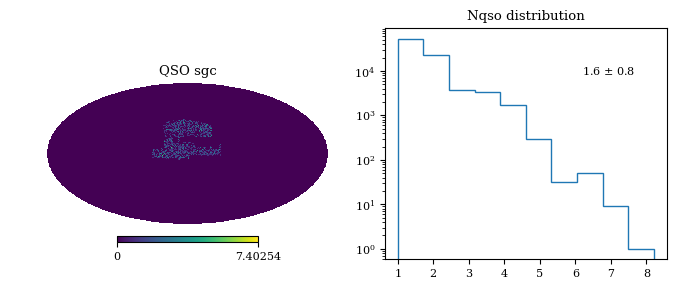

len of gal cats 1
num of gal obj 125501
projecting into a healpix map with nside of 512


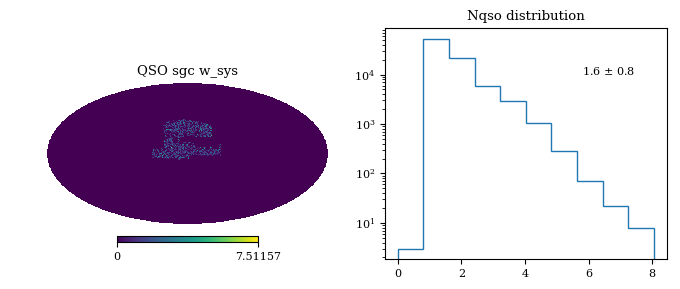

len of gal cats 1
num of gal obj 3587326
projecting into a healpix map with nside of 512


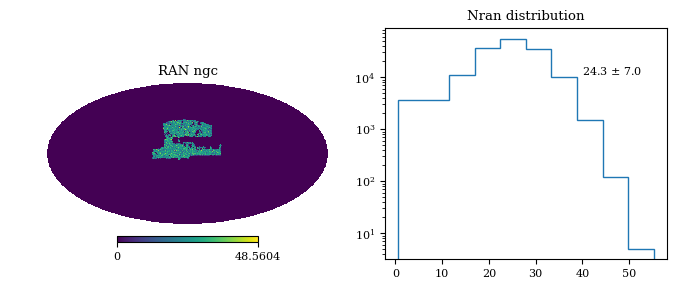

attributes : ('nran', 'sky_g', 'sky_r', 'sky_i', 'sky_z', 'airmass', 'ebv', 'depth_g', 'depth_r', 'depth_i', 'depth_z', 'psf_g', 'psf_r', 'psf_i', 'psf_z', 'w1_med', 'w1_covmed', 'w1_moon', 'star_density')
total mask ran > 0 : 155323
total mask after nan maps : 155282
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145728 entries, 0 to 3145727
Data columns (total 20 columns):
ngal            float64
nran            float64
mask            bool
sky_g           float64
sky_r           float64
sky_i           float64
sky_z           float64
depth_g         float64
depth_r         float64
depth_i         float64
depth_z         float64
psf_g           float64
psf_r           float64
psf_i           float64
psf_z           float64
w1_med          float64
w1_covmed       float64
star_density    float64
ebv             float64
airmass         float64
dtypes: bool(1), float64(19)
memory usage: 459.0 MB
Info :  None



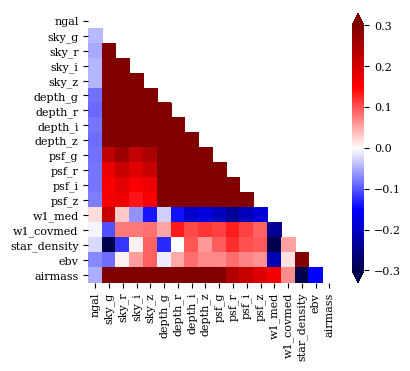

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


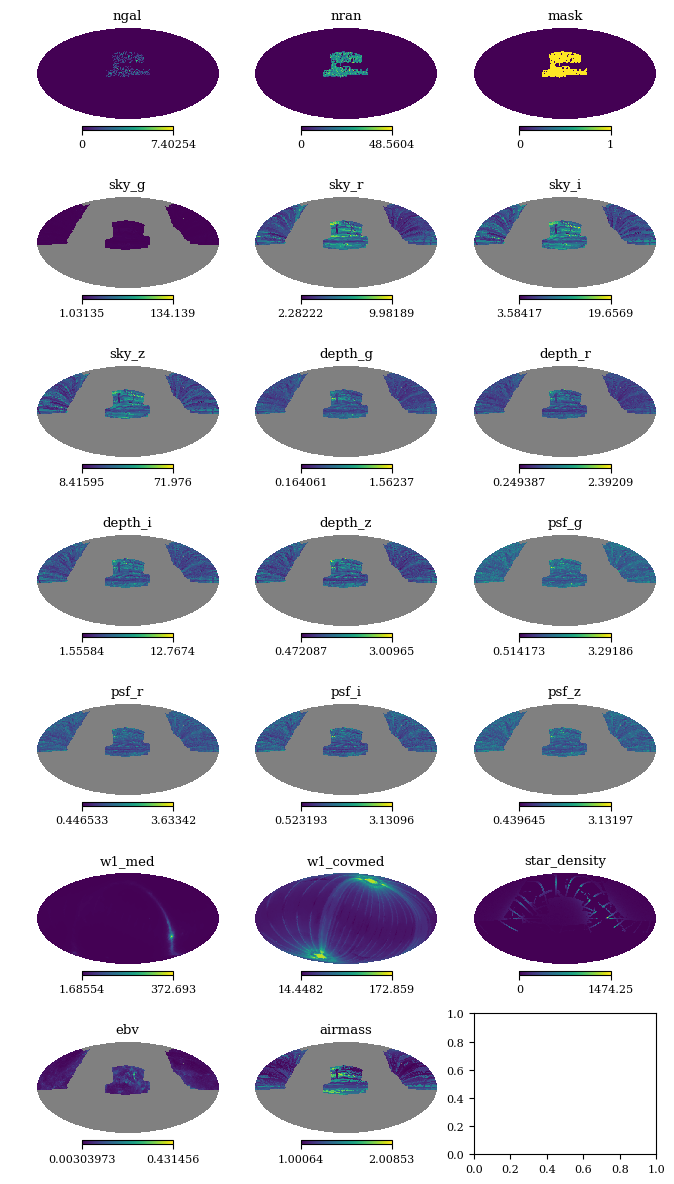

wrote /Volumes/TimeMachine/data/eboss/v6/ngal_features_sgc.fits
wrote /Volumes/TimeMachine/data/eboss/v6/mask.sgc.hp.512.fits
wrote /Volumes/TimeMachine/data/eboss/v6/fracgood.sgc.hp.512.fits


In [5]:
# data
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.dat.fits'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_sgc_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO sgc', 'Nqso distribution'])

# data with systot
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.dat.fits'], 
            weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_sgc_wsys_v6.dat.hp.512.fits')
qsocat.plot_hist(['QSO sgc w_sys', 'Nqso distribution'])

# random
qsocat = CAT([scratch+'eboss/v6/eBOSS_QSO_clustering_SGC_v6.ran.fits'],
             weights=['weight_systot', 'weight_cp', 'weight_noz'])
qsocat.project2hp()
qsocat.writehp(scratch+'eboss/v6/eBOSS_QSO_clustering_sgc_v6.ran.hp.512.fits')
qsocat.plot_hist(['RAN ngc', 'Nran distribution'])

# combine data, random, and imaging attributes
COLS = ['sky_g', 'sky_r', 'sky_i', 'sky_z', 
        'depth_g', 'depth_r', 'depth_i','depth_z',
        'psf_g','psf_r', 'psf_i', 'psf_z',
        'w1_med', 'w1_covmed',
        'star_density', 'ebv', 'airmass']

pdm = combinemaps(scratch+'eboss/v6/eBOSS_QSO_clustering_sgc_v6.dat.hp.512.fits',
                  scratch+'eboss/v6/eBOSS_QSO_clustering_sgc_v6.ran.hp.512.fits',
                  scratch +'/eboss/sysmaps/SDSS_WISE_imageprop_nside512.fits')
pdm.maketable(cols=COLS)
pdm.to_hdf(scratch+'eboss/v6/qso_hpsyst_sgc.hf', 'qso_hpsyst', mode='w', format='fixed')
pdm.plot_corrmax([-.3, .3])
pdm.plot_mollweide()

# read hdf, write label, features to fits
fitname = '/Volumes/TimeMachine/data/eboss/v6/ngal_features_sgc.fits'
metaname = '/Volumes/TimeMachine/data/eboss/v6/qso_hpsyst_sgc.hf'
hpmask   = '/Volumes/TimeMachine/data/eboss/v6/mask.sgc.hp.512.fits'
hpfrac   = '/Volumes/TimeMachine/data/eboss/v6/fracgood.sgc.hp.512.fits'
hd5_2_fits(metaname, fitname, hpmask, hpfrac, COLS)

# randomly split the label features into 5 partitions
ut.read_split_write('/Volumes/TimeMachine/data/eboss/v6/ngal_features_sgc.fits', 
                   '/Volumes/TimeMachine/data/eboss/v6/qso.sgc.hp.512.r',
                   5)

## Ablation

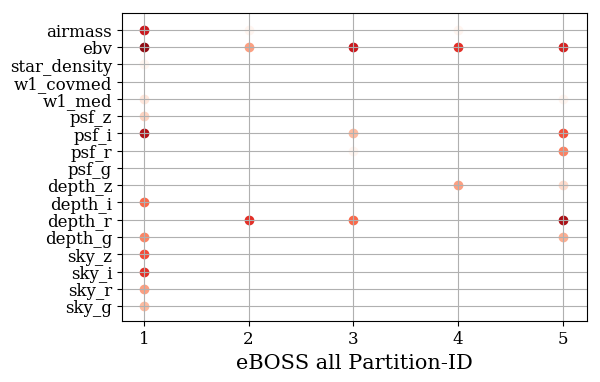

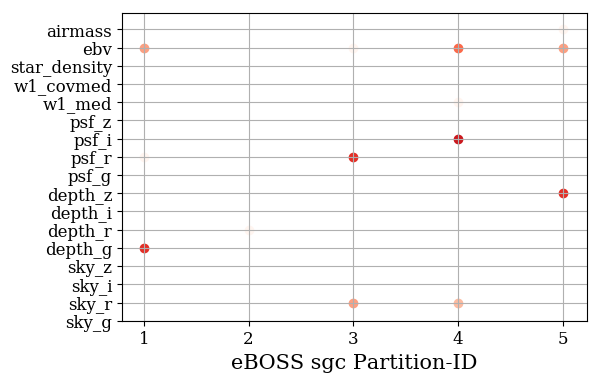

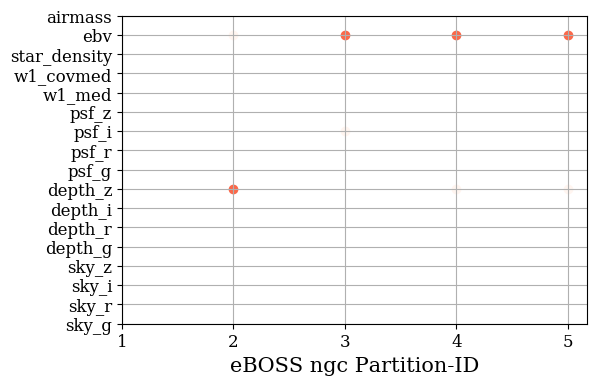

In [2]:
for cap in ['all', 'sgc', 'ngc']:
    hyper_params_data(glob('/Volumes/TimeMachine/data/eboss/v6/results_'+cap+'/ablation/v6.log_fold*.npy'), ['eBOSS '+cap])

In [4]:
nns  = glob('/Volumes/TimeMachine/data/eboss/v6/results_/regression/*/nn-weights.hp512.fits')
masks = glob('/Volumes/TimeMachine/data/eboss/v6/mask.*.hp.512.fits')
nns, masks

(['/Volumes/TimeMachine/data/eboss/v6/results_all/regression/nn_ab/nn-weights.hp512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/results_all/regression/nn_p/nn-weights.hp512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/results_ngc/regression/nn_ab/nn-weights.hp512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/results_ngc/regression/nn_p/nn-weights.hp512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/results_sgc/regression/nn_ab/nn-weights.hp512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/results_sgc/regression/nn_p/nn-weights.hp512.fits'],
 ['/Volumes/TimeMachine/data/eboss/v6/mask.all.cut.hp.512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/mask.all.hp.512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/mask.ngc.cut.hp.512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/mask.ngc.hp.512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/mask.sgc.cut.hp.512.fits',
  '/Volumes/TimeMachine/data/eboss/v6/mask.sgc.hp.512.fits'])

/Volumes/TimeMachine/data/eboss/v6/results/regression/mult_all/lin-weights.hp512.fits
0.44903991209073535 1.3676287426929763
/Volumes/TimeMachine/data/eboss/v6/results/regression/mult_all/quad-weights.hp512.fits
0.37080637803528593 1.5176027062319724
/Volumes/TimeMachine/data/eboss/v6/results/regression/nn_ab/nn-weights.hp512.fits
0.31029618263812286 1.2271591165416917
/Volumes/TimeMachine/data/eboss/v6/results/regression/nn_p/nn-weights.hp512.fits
-0.1362557086903159 3.003935694171566


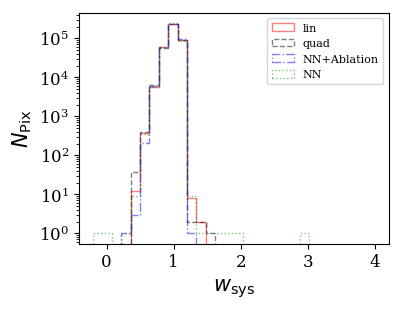

In [4]:
mpl.rcParams.update(mpl.rcParamsDefault)
params = {
'axes.spines.right':True,
'axes.spines.top':True,
'axes.labelsize': 15,
#'text.fontsize': 8,
'legend.fontsize': 8,
'xtick.labelsize': 12,
'ytick.labelsize': 12,
'text.usetex': False,
'figure.figsize': [4, 3],
'font.family':'serif',
'font.size':12
}    
plt.rcParams.update(params) 
ls = ['-', '--', '-.', ':']
lt = ['lin', 'quad', 'NN+Ablation', 'NN']
cl = ['r', 'k', 'b', 'g']
for i,nni in enumerate(nns):
    print(nni)
    nnd = hp.read_map(nni, verbose=False)[mask]
    print(nnd.min(), nnd.max())
    plt.hist(nnd, range=(-0.2, 4), 
             alpha=0.5, bins=30, histtype='step',
             linestyle=ls[i], label=lt[i], color=cl[i])
plt.yscale('log')
plt.ylabel(r'$N_{\rm Pix}$')
plt.xlabel(r'$w_{\rm sys}$')
plt.legend()
_=plt.show()

In [6]:
kw = {'verbose':False}
ngal = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_all_v6.dat.hp.512.fits', **kw)
mask = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/mask.hp.512.fits', **kw).astype('bool')
frac = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/fracgood.hp.512.fits', **kw)
nnw  = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/results/regression/nn_ab/nn-weights.hp512.fits', **kw)

In [7]:
nnbar  = ut.makedelta(ngal, weight1=frac, mask=mask) + 1.0
nnw    = nnw / np.mean(nnw[mask])

# nnw[~mask] = np.mean(nnw[mask])
# nnw = hp.smoothing(nnw.copy(), sigma=np.deg2rad(0.1))
nnbarc = ut.makedelta(ngal, weight1=frac, mask=mask, select_fun=nnw) + 1.0

/Users/rezaie/github/SYSNet/src/utils.py:139: RuntimeWarning: divide by zero encountered in true_divide
  gmap = map1 / select_fun
/Users/rezaie/github/SYSNet/src/utils.py:139: RuntimeWarning: invalid value encountered in true_divide
  gmap = map1 / select_fun


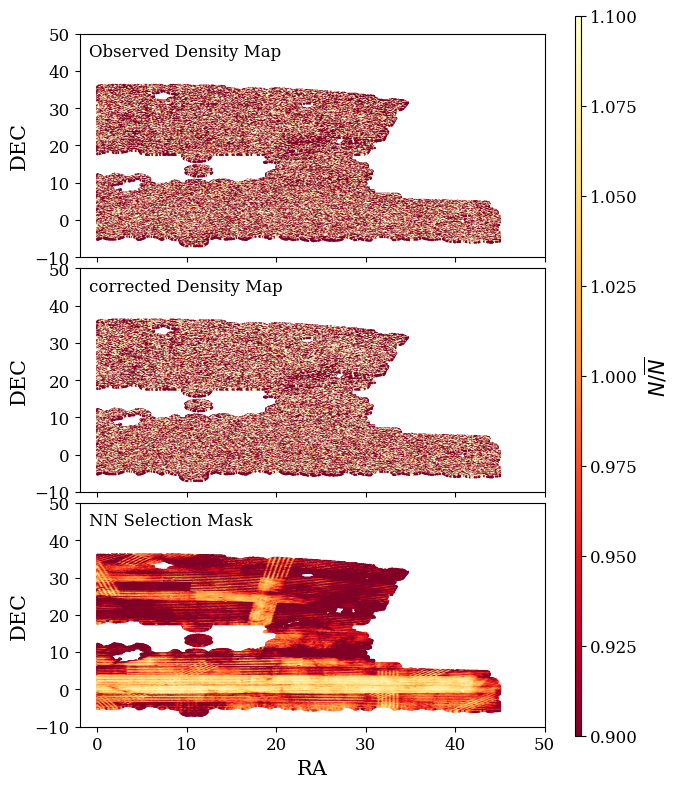

In [8]:
# plt.rc('axes.spines', top=False, right=False)
# plt.rc('font', family='serif')
# plt.rc('text', usetex=True)
hpix = np.argwhere(mask).flatten()
fig, ax = plt.subplots(nrows=3, figsize=(6, 9), sharex=True)
plt.subplots_adjust(hspace=0.05)


#ttl = ['No weights', 'Linear weights', 'NN weights']
ttl = ['Observed Density Map', 'corrected Density Map','NN Selection Mask', ]
#for i,di in enumerate([duni, dlin, dnn]):
for i,di in enumerate([nnbar, nnbarc, nnw]):
    radec = ut.hpix2radec(512, hpix)
    map1 = ax[i].scatter(radec[0], radec[1], 0.5, 
                         #c=5*di[mask], vmin=-1, vmax=1.,
                        c=di[mask], vmin=0.9, vmax=1.1,
                        cmap=plt.cm.YlOrRd_r)
    ax[i].text(0.02, 0.9, ttl[i], transform=ax[i].transAxes)
    ax[-1].set_xlabel('RA')
    ax[i].set_ylabel('DEC')
    ax[i].axis([-2, 50, -10., 50.])
cax = plt.axes([.95, 0.1, 0.01, 0.8])
fig.colorbar(map1, cax=cax, label=r'$N/\overline{N}$')
plt.show()
# plt.savefig('./deltas.png', bbox_inches='tight', dpi=300)

In [9]:
!ls /Volumes/TimeMachine/data/eboss/v6/results/clustering

cl_lin.log      cl_quad.log     nnbar_lin.log   nnbar_quad.log  xi_nn_ab.npy
cl_lin.npy      cl_quad.npy     nnbar_lin.npy   nnbar_quad.npy  xi_nn_p.log
cl_lin.png      cl_quad.png     nnbar_lin.png   nnbar_quad.png  xi_nn_p.npy
cl_nn_ab.log    cl_sys.log      nnbar_nn_ab.log nnbar_uni.log   xi_quad.log
cl_nn_ab.npy    cl_sys.npy      nnbar_nn_ab.npy nnbar_uni.npy   xi_quad.npy
cl_nn_ab.png    cl_sys.png      nnbar_nn_ab.png nnbar_uni.png   xi_sys.log
cl_nn_p.log     cl_uni.log      nnbar_nn_p.log  xi_lin.log      xi_sys.npy
cl_nn_p.npy     cl_uni.npy      nnbar_nn_p.npy  xi_lin.npy      xi_uni.log
cl_nn_p.png     cl_uni.png      nnbar_nn_p.png  xi_nn_ab.log    xi_uni.npy


In [10]:
nnbars = glob('/Volumes/TimeMachine/data/eboss/v6/results/clustering/nnbar_*.npy')
nnbars

['/Volumes/TimeMachine/data/eboss/v6/results/clustering/nnbar_lin.npy',
 '/Volumes/TimeMachine/data/eboss/v6/results/clustering/nnbar_nn_ab.npy',
 '/Volumes/TimeMachine/data/eboss/v6/results/clustering/nnbar_nn_p.npy',
 '/Volumes/TimeMachine/data/eboss/v6/results/clustering/nnbar_quad.npy',
 '/Volumes/TimeMachine/data/eboss/v6/results/clustering/nnbar_uni.npy']

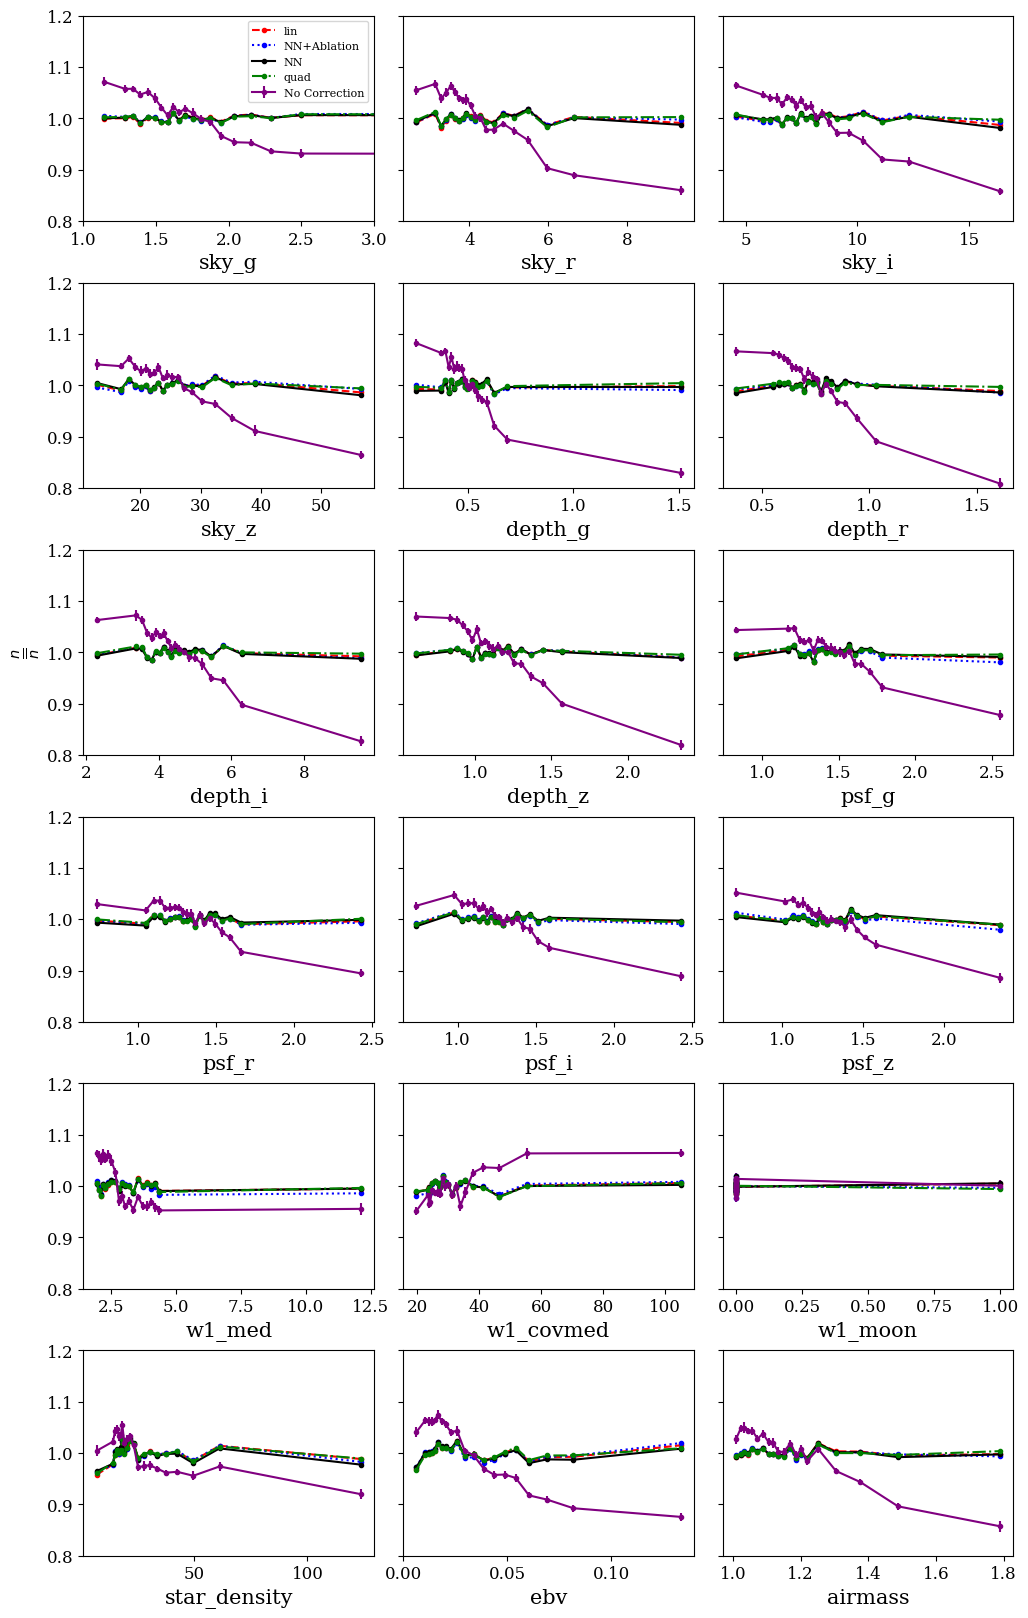

In [19]:
mpl.rcParams.update(mpl.rcParamsDefault)
params = {
'axes.spines.right':True,
'axes.spines.top':True,
'axes.labelsize': 15,
#'text.fontsize': 8,
'legend.fontsize': 8,
'xtick.labelsize': 12,
'ytick.labelsize': 12,
'text.usetex': False,
'figure.figsize': [4, 3],
'font.family':'serif',
'font.size':12
}    
plt.rcParams.update(params) 

fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(12, 20), sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.1)
ax = ax.flatten()

lt = ['lin', 'NN+Ablation', 'NN', 'quad', 'No Correction']
cl = ['r', 'b', 'k', 'g', 'purple']
ls = ['--', ':', '-', '-.', '-']
for j,nnbar_i in enumerate(nnbars):
    nnbar = np.load(nnbar_i).item()
    for i in range(len(nnbar['nnbar'])):
        mynnb = nnbar['nnbar'][i]
        x = 0.5*(mynnb['bin_edges'][1:]+mynnb['bin_edges'][:-1])
        y = mynnb['nnbar']
        ye = mynnb['nnbar_err']
        if j==4:
            ax[i].errorbar(x, y, yerr=ye,marker='.', color=cl[j], linestyle=ls[j], label=lt[j])
        else:
            
            ax[i].plot(x, y, marker='.', color=cl[j], linestyle=ls[j], label=lt[j])
        if j ==4:
            ax[0].legend()
            ax[0].set_xlim(1, 3)
            ax[i].set_ylim(0.8, 1.2)
            ax[i].set_xlabel(nnbar['xlabels'][i])
            if i==6:ax[i].set_ylabel(r'$\frac{n}{\overline{n}}$')
plt.show()                

In [20]:
kw   = dict(verbose=False)
frac = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/fracgood.hp.512.fits', **kw)
mask = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/mask.cut.hp.512.fits', **kw).astype('bool')
ngal = hp.read_map('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_all_v6.dat.hp.512.fits', **kw)

area = hp.nside2pixarea(512, degrees=True)*frac[mask].sum()*3.0462e-4
shotnoise = area/ngal[mask].sum()
print('shotnoise,', area/ngal[mask].sum())
print('fsky', frac[mask].sum()/mask.size)

shotnoise, 4.295060549836234e-06
fsky 0.12477026862386136


In [50]:
def plot_clxi(filen, filen2, ax, ttl):    
    mpl.rcParams.update(mpl.rcParamsDefault)
    params = {
    'axes.spines.right':True,
    'axes.spines.top':True,
    'axes.labelsize': 15,
    #'text.fontsize': 8,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False,
    'figure.figsize': [4, 3],
    'font.family':'serif',
    'font.size':12
    }    
    plt.rcParams.update(params) 

    lb = ['uni', 'uni_wsys', 'nn_ab']
    lt = ['no correction', 'systot', 'nn']
    c  = ['k', 'royalblue', 'crimson', 'g', '', 'purple']
    ls = ['-', '--', '-', '-.', '', '-']

#     fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
#     plt.subplots_adjust(wspace=0.4)

    kw = dict(bins=np.logspace(np.log10(0.9), np.log10(1030), 10))
    for i,lbi in enumerate(lb):
        cl = np.load(filen(lbi)).item()
        elb, clbe = ut.binit_jac(cl['clerr']['cljks'], **kw)
        elb, clb  = ut.binit(np.arange(cl['auto'].size), cl['auto'], **kw)
        #print(clb)
        ax[0].errorbar(elb, clb, yerr=clbe, marker='.', linestyle=ls[i], color=c[i], label=lt[i])
    ax[0].legend(title=ttl)
    ax[0].loglog()
    ax[0].set_ylim(1.e-7, 1.e-2)
    ax[0].set_xlabel(r'$\ell$')
    ax[0].set_ylabel(r'$C_{\ell}$')

    fc = 1.e2
    for i, xii in enumerate(lb):
        d = np.load(filen2(xii)).item()['auto']
        t  = 0.5*np.degrees(d['t'][1:]+d['t'][:-1])
        xi = fc*(d['w']-d['dmean']*d['dmean'])

        xierr=d['werr']
        ax[1].errorbar(t, xi, yerr=fc*xierr, linestyle=ls[i], color=c[i], label=lt[i])
        #ax[0].legend(bbox_to_anchor=(0, 1.1, 2, 0.4), loc="lower left",
        #            mode="expand", borderaxespad=0, ncol=3, frameon=False)    
        ax[1].set_xlabel(r'$\theta [deg]$')
        ax[1].set_ylabel(r'$10^{2}\times \omega(\theta)$')
        ax[1].set_xlim(-0.2, 10)
        ax[1].set_ylim(-0.5, 2.0)
        ax[1].grid()
    #plt.show()

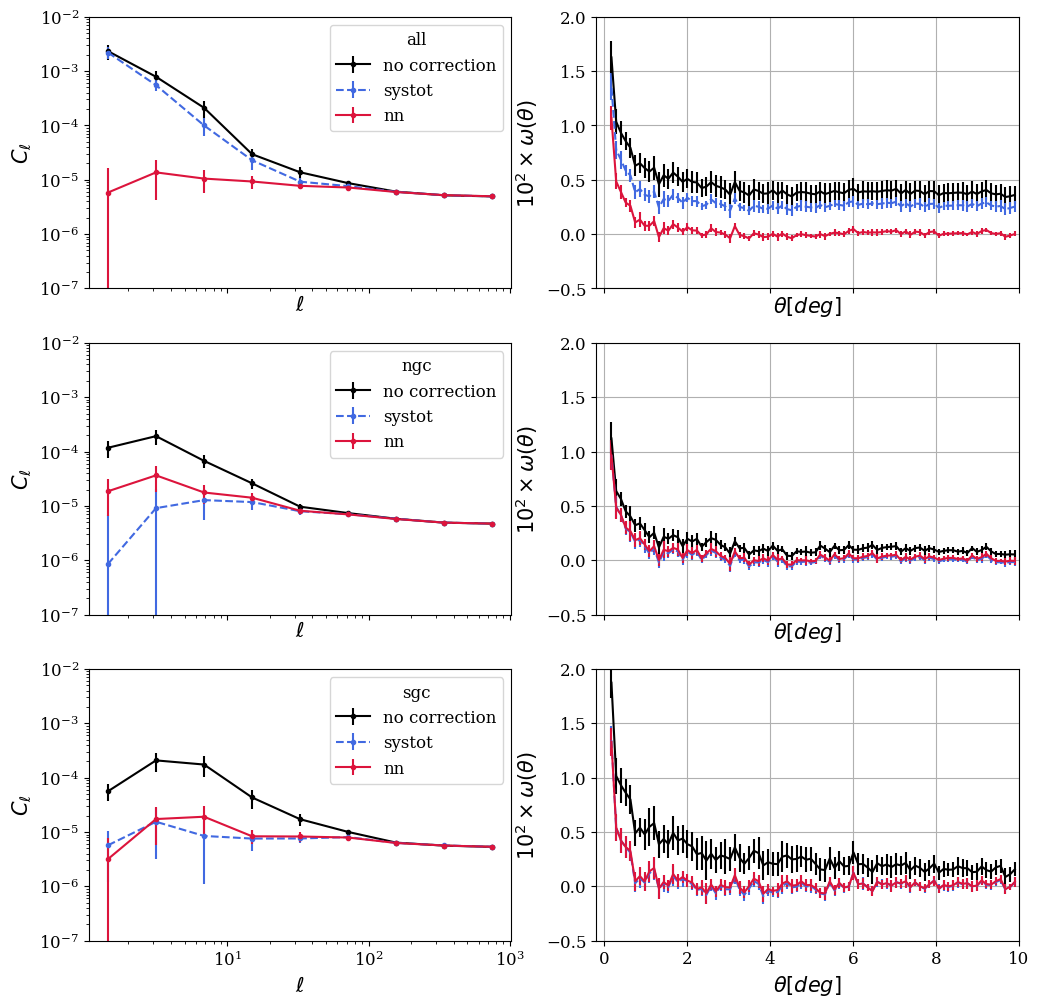

In [51]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 12), sharex='col')
ax = ax.flatten()
# plt.subplots_adjust(hspace=0.0)

for i,cap in enumerate(['all', 'ngc', 'sgc']):
    filen = lambda l:'/Volumes/TimeMachine/data/eboss/v6/results_'+cap+'/clustering/cl_'+l+'.npy'
    filen2 = lambda l:'/Volumes/TimeMachine/data/eboss/v6/results_'+cap+'/clustering/xi_'+l+'.npy'
    plot_clxi(filen, filen2, [ax[2*i], ax[2*i+1]], cap)
plt.show()